In [1]:
import requests
import json
import time
import copy
import pandas as pd
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
from mpl_finance import candlestick2_ohlc
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from matplotlib.dates import date2num, DayLocator, DateFormatter
pd.options.display.max_rows = 10
%config InlineBackend.figure_format = 'svg'
API_KEY = "MQ6BIXLQCTZ9I3DV"

In [2]:
def prices_from_json_response(apikey,symbol,function,outputsize):#dataframe цен вида акций из json из api alphavanttage
    API_URL = "https://www.alphavantage.co/query"
    data = {
        "function": function,
        "symbol": symbol,
        "outputsize": outputsize,
        "datatype": "JSON",
        "apikey": apikey
        }
    json_data=requests.get(API_URL, data).json()['Time Series (Daily)']
    prices=pd.DataFrame(json_data).transpose()
    prices.index.names = ['Date']
    prices.index=pd.to_datetime(prices.index, format='%Y-%m-%d')
    if function=='TIME_SERIES_DAILY':
        prices=prices.rename(columns={"1. open" : "open", "2. high":"high", "3. low":"low", "4. close":"close", "5. volume":"volume"})
    if function=='TIME_SERIES_DAILY_ADJUSTED':
        prices=prices.rename(columns={"1. open" : "open", "2. high":"high", "3. low":"low", "4. close":"close", "5. adjusted close":"adjusted close","6. volume":"volume","7. dividend amount":"dividend amount","8. split coefficient":"split coefficient"})
    prices=prices.astype(float)
    prices = prices.sort_index(axis=0 ,ascending=True)
    return prices

In [3]:
def prices_from_csv_response(apikey,symbol,function,outputsize):#dataframe цен вида акций из scv из api alphavanttage
    base_url = 'https://www.alphavantage.co/query?'
    request_url = base_url + '&'.join\
        (['function=' + function,
          'outputsize=' + outputsize,
          'datatype=' + 'csv',
          'symbol=' + symbol,
          'apikey=' + apikey])
    data = pd.read_csv(request_url, index_col='timestamp', parse_dates=True)    
    data=data.iloc[::-1]
    data.index.names = ['Date']
    return data

In [4]:
def prices_from_alphavantage_response(#dataframe цен вида акций из api alphavanttage
        apikey, symbol,datatype,
        function='TIME_SERIES_DAILY_ADJUSTED',
        outputsize='compact'):
        if datatype=="JSON" or datatype=="json":
            return prices_from_json_response(apikey,symbol,function,outputsize)
        elif datatype=="CSV" or datatype=="csv":
            return prices_from_csv_response(apikey,symbol,function,outputsize)
        else:
            print("Not supported format")

In [5]:
def read_prices_df_from_csv(name):#читает df цен из файла
    return(pd.read_csv(name+'.csv',index_col='Date'))

In [6]:
def readydf(df,startdate):#отсекает часть данных от начала файлы до даты startdate
    return df[df.index>=startdate]

In [7]:
def getbollinger(prices,window=3,safety=1):#создаёт dataframe для стратегии Боллинжера
    bollingerprices=prices
    bollingerprices["close rolling"]=prices["close"].rolling(window).mean()
    tmp=safety*prices["close"].rolling(window).std()
    bollingerprices["close top"]=bollingerprices["close rolling"]+tmp
    bollingerprices["close bottom"]=bollingerprices["close rolling"]-tmp
    #first_date=bollingerprices.first_valid_index()
    #first_clean_date=first_date+pd.DateOffset(days=window)
    return bollingerprices.iloc[window:]

In [8]:
def getcrossover(prices,small_window=3,big_window=30):#создаёт df для стратегии пересечения скользящих средних
    if (big_window<small_window):
        print("Wrong window settings")
        return
    prices["Fast close rolling"]=prices["close"].rolling(small_window).mean()
    prices["Slow close rolling"]=prices["close"].rolling(big_window).mean()
    return prices.iloc[big_window:]

In [9]:
def drawcandlestick(df):#рисует японские свечки для df цен вида акций
    fig, ax = plt.subplots(figsize=(7, 7))
    candlestick2_ohlc(ax,df['open'],df['high'],df['low'],df['close'],width=0.5) 
    ax.xaxis.set_major_locator(ticker.MaxNLocator(10))
    xdate = df.index.date
    def mydate(x,pos):
        try:
            return xdate[int(x)]
        except IndexError:
            return ''
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(mydate))
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

In [10]:
def drawbollinger(bollingerprices):#рисует график цен, скользящее среднее и линии Боллинжера для df цен вида акций
    color='#0066FF'
    fig,ax = plt.subplots(figsize=(8, 8))
    ax.set_title('Price and Bollinger Bands')
    ax.set_xlabel('Date')
    ax.set_ylabel('SMA and Bollinger Bands')
    ax.plot(bollingerprices.index, bollingerprices["close rolling"], color=color)
    ax.fill_between(
            bollingerprices.index,  
            bollingerprices["close bottom"],
            bollingerprices["close top"],
            color=color, alpha=0.1)
    ax.plot(
            bollingerprices.index,  
            bollingerprices["close bottom"],
            bollingerprices["close top"],
            color=color, linewidth=1, alpha=0.4)
    #ax.plot(bollingerprices.index, bollingerprices["close"],
            #color=color, linewidth=1, alpha=0.4)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(10))
    myFmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(myFmt)
    fig.autofmt_xdate()
    #fig.tight_layout()

In [11]:
def drawcrossover(prices):#рисует скользящии среднии для df цен вида акций
    fig,ax = plt.subplots(figsize=(12, 8))
    ax.set_title('Price and moving averages')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price and moving averages')
    ax.plot(prices.index, prices["Fast close rolling"], color="gray")
    ax.plot(prices.index, prices["Slow close rolling"], color="black")
    ax.plot(prices.index, prices["close"],color="red")
    ax.xaxis.set_major_locator(ticker.MaxNLocator(10))
    myFmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(myFmt)
    fig.autofmt_xdate()

In [12]:
class result_of_trading:
    cash=0
    amount=0
    profit=0
    percentage_profit=0
    transactions = pd.DataFrame(columns=["buy/sell","date","price","amount"])
    def __str__(self):
        s="Profit="+str(self.profit)+"$"+"\n"
        s=s+"Percentage profit="+str(self.percentage_profit)+"\n"
        s=s+"Amount="+str(self.amount)+"\n"
        s=s+"Cash="+str(round(self.cash,10))+"$"+"\n"
        s=s+str(self.transactions)+"\n"
        return s
    def sell(self,prices,i):
        if (self.amount>0):
            selling_amount=rnd.randint(round(0.7*self.amount),self.amount)
            if(selling_amount>0):
                tmp=prices.loc[i,"close"]
                self.cash=self.cash+tmp*selling_amount
                self.amount=self.amount-selling_amount
                transaction=pd.DataFrame([["sell",i,tmp,selling_amount]],columns=["buy/sell","date","price","amount"])
                self.transactions= pd.concat([self.transactions,transaction],ignore_index=True)
    def buy(self,prices,i):
        tmp=prices.loc[i,"close"]
        max_amount=self.cash//tmp
        buying_amount=rnd.randint(round(0.7*max_amount),max_amount)
        if(buying_amount>0):
            self.amount=self.amount+buying_amount
            self.cash=self.cash-tmp*buying_amount
            transaction=pd.DataFrame([["buy",i,tmp,buying_amount]],columns=["buy/sell","date","price","amount"])
            self.transactions= pd.concat([self.transactions,transaction],ignore_index=True)

In [13]:
def simplebolinger(original_prices,amount,startdate):#реализация простейшей стратегии Боллинжера
    prices=getbollinger(original_prices)
    prices=readydf(prices,startdate)
    drawbollinger(prices)
    ans=result_of_trading()
    start_capital=prices["close"].iloc[0]*amount
    ans.amount=amount
    ans.cash=0
    for i in prices.index:
        if prices.loc[i,"close"]>prices.loc[i,"close top"]:
            ans.sell(prices,i)
        if prices.loc[i,"close"]<prices.loc[i,"close bottom"]:
            ans.buy(prices,i)
    end_capital=prices.iloc[-1:]["close"][0]*ans.amount+ans.cash
    ans.profit=end_capital-start_capital
    ans.profit=round(ans.profit,10)
    ans.percentage_profit=round(100*ans.profit/start_capital,1)
    ans.percentage_profit=str(ans.percentage_profit)+"%"
    return ans

In [14]:
def crossover(original_prices,amount,startdate):#реализация простейшей стратегии пересечения скользящих средних
    prices=getcrossover(original_prices)
    prices=readydf(prices,startdate)
    drawcrossover(prices)
    ans=result_of_trading()
    start_capital=prices["close"].iloc[0]*amount
    ans.amount=amount
    ans.cash=0
    for i in prices.index:
        if prices.loc[i,"Fast close rolling"]<prices.loc[i,"Slow close rolling"]:
            ans.sell(prices,i)
        if prices.loc[i,"Fast close rolling"]>prices.loc[i,"Slow close rolling"]:
            ans.buy(prices,i)
    end_capital=prices.iloc[-1:]["close"][0]*ans.amount+ans.cash
    ans.profit=end_capital-start_capital
    ans.profit=round(ans.profit,10)
    ans.percentage_profit=round(100*ans.profit/start_capital,1)
    ans.percentage_profit=str(ans.percentage_profit)+"%"
    return ans

In [15]:
def read_poprtfolio_df(name):#cчитывает портфель из csv файла
    return(pd.read_csv(name+'.csv',names=['symbol','amount']))

In [16]:
def loadprices(portfolio):#загружает list dfов цен портфеля
    prices_list=list()
    for i in portfolio.index:
        prices_list.append(prices_from_alphavantage_response(API_KEY,portfolio.loc[i,"symbol"],"csv"))
    return prices_list

In [17]:
def trade_portfolio(portfolio,prices_list,startdate,trade_func):#возвращает результат торговли портфеля для функции trade_func
    results=list()
    for i in range(len(prices_list)):
        results.append(trade_func(prices_list[i],portfolio.loc[i,"amount"],startdate))
    return results

In [18]:
def show_results(results):
    total_profit=0
    for i in results:
        print(i,'\n')
        total_profit=total_profit+round(i.profit,10)
    print("Total profit =",total_profit,"$")

In [19]:
#TO DO 

#функция которая рисует графики цен для 2х видов акций и вычисляет кореляции
#(матрица корреляции
#гистограммы корреляция)


#свечки — объём продаж
#комментарии(документация в markdown для каждой функции)


#желательное окно/настоящее окно
#plotly
#добавить стратегий    

In [20]:
file_name="Portfolio"
startdate="2018-11-14"
portfolio=read_poprtfolio_df(file_name)
prices_list=loadprices(portfolio)

In [21]:
portfolio

,symbol,amount
0,AAPL,100
1,MSFT,200


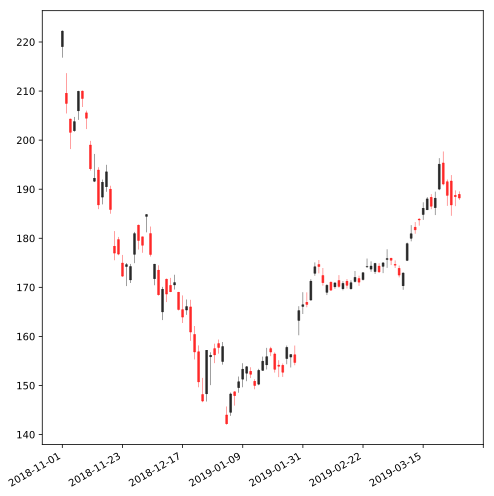

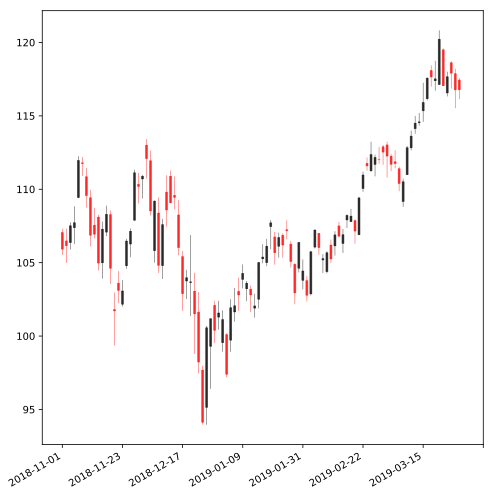

In [22]:
for i in prices_list:
    drawcandlestick(i)

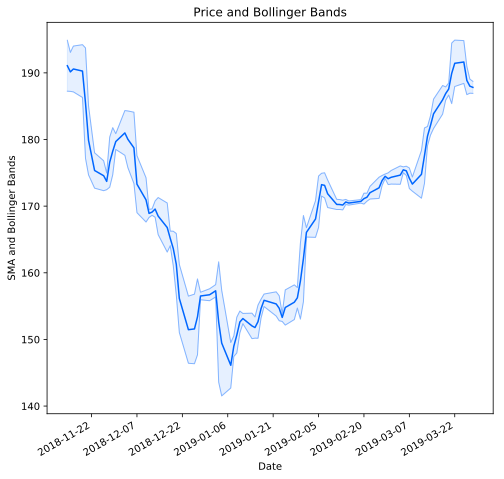

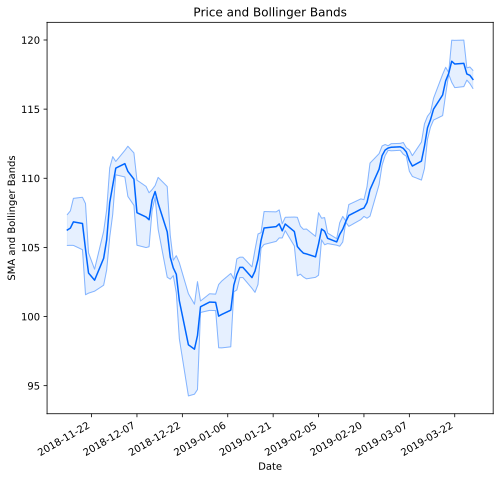

In [23]:
results_bollinger=trade_portfolio(portfolio,prices_list,startdate,simplebolinger)

In [24]:
show_results(results_bollinger)

Profit=2722.7$
Percentage profit=14.6%
Amount=0
Cash=21402.7$
   buy/sell       date   price amount
0      sell 2018-11-28  180.94     78
1      sell 2018-12-03  184.82     19
2       buy 2018-12-07  168.49     87
3      sell 2018-12-13  170.95     84
4       buy 2018-12-14  165.48     91
..      ...        ...     ...    ...
24      buy 2019-03-07  172.50     10
25     sell 2019-03-11  178.90    103
26     sell 2019-03-14  183.73     13
27     sell 2019-03-15  186.12      1
28     sell 2019-03-21  195.09      1

[29 rows x 4 columns]
 

Profit=1270.86$
Percentage profit=6.1%
Amount=174
Cash=1946.01$
   buy/sell       date   price amount
0      sell 2018-11-26  106.47    147
1      sell 2018-11-28  111.12     45
2      sell 2018-12-03  112.09      8
3       buy 2018-12-04  108.52    141
4       buy 2018-12-07  104.82     51
..      ...        ...     ...    ...
21      buy 2019-03-07  110.39     41
22     sell 2019-03-11  112.83    129
23     sell 2019-03-13  114.50     50
24     sell 

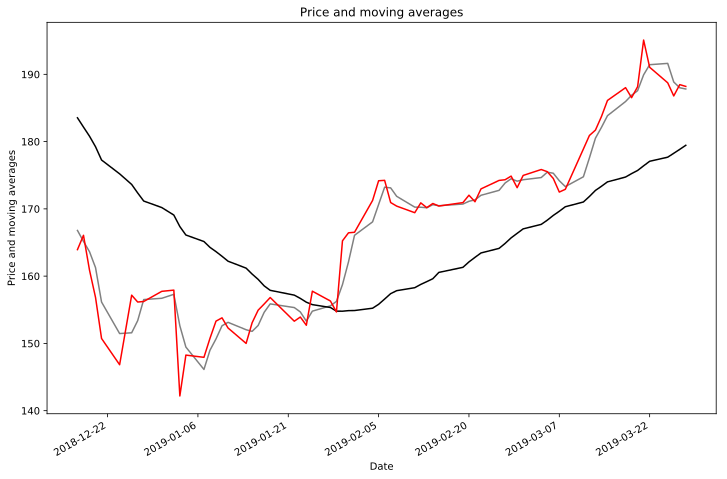

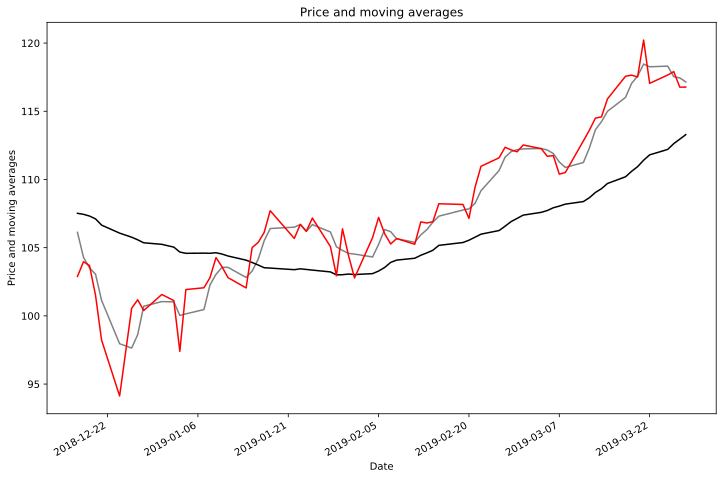

In [25]:
results_crossover=trade_portfolio(portfolio,prices_list,startdate,crossover)

In [26]:
show_results(results_crossover)

Profit=3400.635$
Percentage profit=20.7%
Amount=105
Cash=33.11$
  buy/sell       date   price amount
0     sell 2018-12-17  163.94     77
1     sell 2018-12-18  166.07     23
2      buy 2019-01-28  156.30    104
3      buy 2019-01-29  154.68      1
 

Profit=2196.465$
Percentage profit=10.7%
Amount=195
Cash=3.34$
  buy/sell       date   price amount
0     sell 2018-12-17  102.89    175
1     sell 2018-12-18  103.97     20
2     sell 2018-12-19  103.69      4
3     sell 2018-12-20  101.51      1
4      buy 2019-01-16  105.38    146
5      buy 2019-01-17  106.12     41
6      buy 2019-01-18  107.71      8
 

Total profit = 5597.1 $
